# Topic Modeling, Text Dimension Reduction

In [1]:
%%capture
!pip install ipypublish
!pip install transformers

In [2]:
%pylab inline
import pandas as pd
import os
from ipypublish import nb_setup
# %load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Teaching/NLP')

Mounted at /content/drive


## Topic Modeling using LDA

This is a nice article that has most of what is needed: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

## LDA Explained (Briefly)

Latent Dirichlet Allocation (LDA) was created by David Blei, Andrew Ng, and Michael Jordan in 2003, see their paper titled "Latent Dirichlet Allocation" in the *Journal of Machine Learning Research*, pp 993--1022: http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

The simplest way to think about LDA is as a probability model that connects documents with words and topics. The components are:

- A Vocabulary of $V$ words, i.e., $w_1,w_2,...,w_i,...,w_V$, each word indexed by $i$.
- A Document is a vector of $N$ words, i.e., ${\bf w}$.
- A Corpus $D$ is a collection of $M$ documents, each document indexed by $j$, i.e. $d_j$.

Next, we connect the above objects to $K$ topics, indexed by $l$, i.e., $t_l$.  We will see that LDA is encapsulated (conceptually) in two matrices: Matrix $A$ and Matrix $B$.  

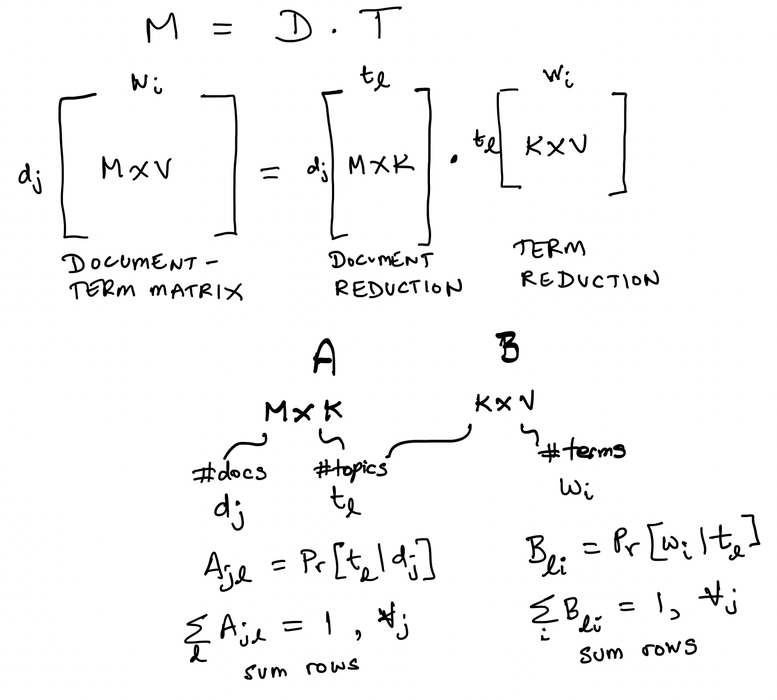

In [ ]:
## LDA Decomposition

nb_setup.images_hconcat(['NLP_images/LDA_decomp.png'], width=800)

## Matrix $A$: Connecting Documents with Topics

- This matrix has documents on the rows, so there are $M$ rows.
- The topics are on the columns, so there are $K$ columns.
- Therefore $A \in {\cal R}^{M \times K}$.
- The row sums equal $1$, i.e., for each document, we have a probability that it pertains to a given topic, i.e., $A_{jl} = Pr[t_l | d_j]$, and $\sum_{l=1}^K A_{jl} = 1$.

## Matrix $B$: Connecting Words with Topics

- This matrix has topics on the rows, so there are $K$ rows.
- The words are on the columns, so there are $V$ columns.
- Therefore $B \in {\cal R}^{K \times V}$.
- The row sums equal $1$, i.e., for each topic, we have a probability that it pertains to a given word, i.e., $B_{li} = Pr[w_i | t_l]$, and $\sum_{i=1}^V B_{li} = 1$.

## Distribution of Topics in a Document

- This is a [*generative*](https://en.wikipedia.org/wiki/Generative_model) model, i.e., we have a prior on topics in documents from which we sample to create a topic vector with probabilities of dimension $K$, adding up to 1. (Compare this to *discriminative* models.)
- Using Matrix $A$, we can sample a $K$-vector of probabilities of topics for a single document. Denote the probability of this vector as $p(\theta | \alpha)$, where $\theta, \alpha \in {\cal R}^K$, $\theta, \alpha \geq 0$, and $\sum_l \theta_l = 1$.  
- The probability $p(\theta | \alpha)$ is governed by a Dirichlet distribution, with density function

$$
p(\theta | \alpha) = \frac{\Gamma(\sum_{l=1}^K \alpha_l)}{\prod_{l=1}^K \Gamma(\alpha_l)} \; \prod_{l=1}^K \theta_l^{\alpha_l - 1}
$$

where $\Gamma(\cdot)$ is the Gamma function.
- LDA thus gets its name from the use of the Dirichlet distribution, embodied in Matrix $A$. Since the topics are latent, it explains the rest of the nomenclature.
- Given $\theta$, we sample topics from matrix $A$ with probability $p(t | \theta)$.

Note: https://en.wikipedia.org/wiki/Dirichlet_distribution

In [6]:
# Dirichlet Basics
alpha = rand(5) # concentration parameters
print("alpha=",alpha)
theta = array([0.1,0.2,0.4,0.2,0.1])  # topic mixture

from scipy.stats import dirichlet
print("PDF of theta =", dirichlet.pdf(theta, alpha))
print("Draw a random theta =", dirichlet.rvs(alpha).round(3))

alpha= [0.07144888 0.00341131 0.39736439 0.33768839 0.67648984]
PDF of theta = 0.012751628826868167
Draw a random theta = [[0.638 0.    0.042 0.208 0.112]]


![](NLP_images/LDA_paper_algebra.png)
[Paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

## Distribution of Words and Topics for a Document

- And then, a generative model for words. 
- The number of words in a document is assumed to be distributed Poisson with parameter $\xi$.
- Matrix $B$ gives the [*multinomial*](https://en.wikipedia.org/wiki/Multinomial_distribution#:~:text=In%20probability%20theory%2C%20the%20multinomial,sided%20dice%20rolled%20n%20times.) probability of a word appearing in a topic, $p(w | t)$.
- The topics mixture is given by $\theta$.
- The joint distribution over $K$ topics and $K$ words for a topic mixture is given by

$$
p(\theta, {\bf t}, {\bf w}) = p(\theta | \alpha) \prod_{l=1}^K p(t_l | \theta) p(w_l | t_l)
$$

- The marginal distribution for a document's words comes from integrating out the topic mixture $\theta$, and summing out the topics ${\bf t}$, i.e.,

$$
p({\bf w}) = \int p(\theta | \alpha) \left(\prod_{l=1}^K \sum_{t_l} p(t_l | \theta) p(w_l | t_l)\; \right) d\theta
$$

## Likelihood of the entire Corpus

- This is given by:

$$
p(D) = \prod_{j=1}^M \int p(\theta_j | \alpha) \left(\prod_{l=1}^K \sum_{t_{jl}} p(t_l | \theta_j) p(w_l | t_l)\; \right) d\theta_j
$$

- The goal is to maximize this likelihood by picking the vector $\alpha$ and the probabilities in the matrix $B$. (Note that were a Dirichlet distribution not used, then we could directly pick values in Matrices $A$ and $B$.)

- The computation is undertaken using MCMC with Gibbs sampling.

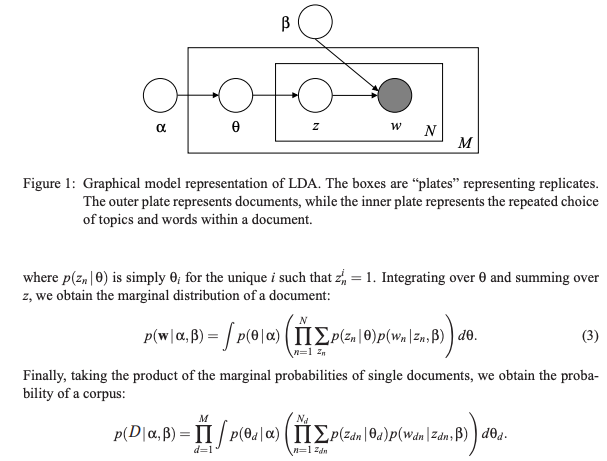

In [ ]:
## Recap LDA

nb_setup.images_hconcat(['NLP_images/LDA_diagram.png'], width=800)

## Load in the Reuters news corpus

This data can be obtained here: 
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/reuters.zip

Please drop it into the folder NLP_data, using the directory structure shown below. 

In [7]:
# Read in text cleaning functions
%run Text_Cleaning_Functions.ipynb

#Read in the corpus
import nltk
from nltk.corpus import PlaintextCorpusReader
corpus_root = 'reuters/training/'
ctext = PlaintextCorpusReader(corpus_root, '.*')

[nltk_data] Downloading package punkt to /Users/longmini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/longmini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Corpus Statistics
print(len(ctext.fileids()))
print(len(ctext.paras()))
print(len(ctext.sents()))
print(len(ctext.words()))
print(len(ctext.raw()))

7769
8471
40277
1253696
6478471


In [9]:
#Convert corpus to text array with a full string for each doc
def merge_arrays(word_lists):
    wordlist = []
    for wl in word_lists:
        wordlist = wordlist + wl
    doc = ' '.join(wordlist)
    return doc

In [10]:
#Run this through the corpus to get a word array for each doc
text_array = []
for p in ctext.paras():
    doc = merge_arrays(p)
    text_array.append(doc)
    
#Clean up the docs using the previous functions
news = text_array
news = removePunc(news)
news = removeNumbers(news)
news = stopText(news)
#news = stemText(news)
news = [j.lower() for j in news]
news[:2]

[' bahia cocoa review showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review the dry period means temporao late year arrivals week ended february bags kilos making cumulative total season mln stage last year again seems cocoa delivered earlier consignment included arrivals figures comissaria smith said still doubt much old crop cocoa still available harvesting practically come end with total bahia crop estimates around mln bags sales standing almost mln hundred thousand bags still hands farmers middlemen exporters processors there doubts much cocoa would fit export shippers experiencing dificulties obtaining bahia superior certificates in view lower quality recent weeks farmers sold good part cocoa held consignment comissaria smith said spot bean prices rose cruzados per arroba kilos bean shippers reluctant offer nearby shipment limited sa

## Lemmatization

Stemming reduces words to their root form. The root form may not be an actual word in the language being processed. The goal of stemming is to reduce the number of forms of the word to a single form, so that when the term-document matrix is constructed, the same word does not appear as different words, as it may conflate the textual analysis being undertaken.

Stemming is a hard problem and a long-standing solution was developed by Porter in 1979. This has stood the test of time. https://tartarus.org/martin/PorterStemmer/. The Lancaster stemmer is more aggressive and was developed in 1990, the source code is quite economical and you can see it here: https://www.nltk.org/_modules/nltk/stem/lancaster.html

Lemmatization is the same as stemming with the additional constraint that the root word is present in the language's dictionary. NLTK uses the WordNet lemmatizer. (WordNet is a widely used word corpus also known as a "lexical database".) See: https://wordnet.princeton.edu/

Additional reading: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

In [11]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

def lemmText(text_array):
    WNlemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for h in text_array:
        words = word_tokenize(h) 
        h2 = ''
        for w in words:
            h2 = h2 + ' ' + WNlemmatizer.lemmatize(w)
        lemmatized_text.append(h2)
    return lemmatized_text

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/longmini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
#Example
bio = [' Citibank His current research interests include machine learning', 
       ' social networks derivatives pricing models portfolio theory', 
       ' modeling default risk systemic risk venture capital He', 
       ' published hundred articles academic journals', 
       ' numerous awards research teaching His recent book', 
       ' Derivatives Principles Practice published May second edition']
temp = stopText(removeNumbers(removePunc(bio)))
print('Original: ',temp, "\n")
bio_lemm = lemmText(temp)
print('Lemmatized: ',bio_lemm, "\n")
bio_stem = stemText(temp)
print('Stemmed: ',bio_stem)

Original:  [' Citibank His current research interests include machine learning', ' social networks derivatives pricing models portfolio theory', ' modeling default risk systemic risk venture capital He', ' published hundred articles academic journals', ' numerous awards research teaching His recent book', ' Derivatives Principles Practice published May second edition'] 

Lemmatized:  [' Citibank His current research interest include machine learning', ' social network derivative pricing model portfolio theory', ' modeling default risk systemic risk venture capital He', ' published hundred article academic journal', ' numerous award research teaching His recent book', ' Derivatives Principles Practice published May second edition'] 

Stemmed:  [' citibank hi current research interest includ machin learn', ' social network deriv price model portfolio theori', ' model default risk system risk ventur capit He', ' publish hundr articl academ journal', ' numer award research teach hi recent 

In [13]:
#Clean and process news documents into shape for LDA
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in news]

In [14]:
print(len(doc_clean))
type(doc_clean)

8471


list

In [15]:
doc_clean[:10]

[['bahia',
  'cocoa',
  'review',
  'shower',
  'continued',
  'throughout',
  'week',
  'bahia',
  'cocoa',
  'zone',
  'alleviating',
  'drought',
  'since',
  'early',
  'january',
  'improving',
  'prospect',
  'coming',
  'temporao',
  'although',
  'normal',
  'humidity',
  'level',
  'restored',
  'comissaria',
  'smith',
  'said',
  'weekly',
  'review',
  'dry',
  'period',
  'mean',
  'temporao',
  'late',
  'year',
  'arrival',
  'week',
  'ended',
  'february',
  'bag',
  'kilo',
  'making',
  'cumulative',
  'total',
  'season',
  'mln',
  'stage',
  'last',
  'year',
  'seems',
  'cocoa',
  'delivered',
  'earlier',
  'consignment',
  'included',
  'arrival',
  'figure',
  'comissaria',
  'smith',
  'said',
  'still',
  'doubt',
  'much',
  'old',
  'crop',
  'cocoa',
  'still',
  'available',
  'harvesting',
  'practically',
  'come',
  'end',
  'total',
  'bahia',
  'crop',
  'estimate',
  'around',
  'mln',
  'bag',
  'sale',
  'standing',
  'almost',
  'mln',
  'hundr

## Gensim for topic analysis

Stands for "generate similar". 

https://radimrehurek.com/gensim/

There are several useful tutorials in this site. 

In [16]:
!pip install gensim

     |████████████████████████████████| 23.9 MB 15.7 MB/s eta 0:00:01


In [17]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our corpus, every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
print(size(doc_term_matrix))
print(type(doc_term_matrix))
print(len(doc_term_matrix[0]))
print(len(doc_term_matrix[1]))

/Users/longmini/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


8471
<class 'list'>
149
86


In [18]:
%%time 
#RUN THE MODEL
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

CPU times: user 6min 2s, sys: 6.53 s, total: 6min 9s
Wall time: 5min 8s


In [19]:
#Results
print(ldamodel.print_topics(num_topics=3, num_words=10))

[(0, '0.039*"said" + 0.019*"lt" + 0.018*"company" + 0.017*"dlrs" + 0.016*"share" + 0.012*"mln" + 0.011*"pct" + 0.008*"inc" + 0.008*"corp" + 0.007*"stock"'), (1, '0.095*"v" + 0.079*"mln" + 0.061*"ct" + 0.047*"net" + 0.044*"loss" + 0.035*"dlrs" + 0.027*"shr" + 0.023*"profit" + 0.022*"lt" + 0.020*"year"'), (2, '0.030*"said" + 0.015*"pct" + 0.012*"u" + 0.010*"year" + 0.010*"billion" + 0.009*"bank" + 0.008*"mln" + 0.007*"market" + 0.007*"trade" + 0.007*"would"')]


### There are two approaches to topic modeling:
    
[1] Latent Semantic Analysis (LSA): implements a matrix decomposition of the DTM $M$ into a $D$ matrix and an $T$, by minimizing the Frobenious norm, i.e., 

$$
\min || M - D \cdot T||_F
$$

Implemented with a truncated SVD. 

[2] LDA: Latent Dirichlet Allocation (discussed above)

## LSA : Latent Semantic Analysis 

See Linear Algebra Notebook 2: [022-LinearAlgebra_Eigensystems_Decompositions](https://drive.google.com/file/d/1apEJu2DtWh2spM_LNiV5aSrF_UenCVNH/view?usp=sharing)

https://srdas.github.io/MLBook2/24_TextAnaytics_Advanced.html#Singular-Value-Decomposition-(SVD)

See R code. 

## text2vec for topic analysis

Code here is taken from: http://text2vec.org/topic_modeling.html

May need: `conda install -c conda-forge r-text2vec`

In [ ]:
%%R
library(stringr)
library(text2vec)
data("movie_review")
# select 1000 rows for faster running times
movie_review_train = movie_review[1:700, ]
movie_review_test = movie_review[701:1000, ]
prep_fun = function(x) {
  # make text lower case
  x = str_to_lower(x)
  # remove non-alphanumeric symbols
  x = str_replace_all(x, "[^[:alpha:]]", " ")
  # collapse multiple spaces
  x = str_replace_all(x, "\\s+", " ")
}
movie_review_train$review = prep_fun(movie_review_train$review)
it = itoken(movie_review_train$review, progressbar = FALSE)
v = create_vocabulary(it)
v = prune_vocabulary(v, doc_proportion_max = 0.1, term_count_min = 5)
vectorizer = vocab_vectorizer(v)
dtm = create_dtm(it, vectorizer)

In [ ]:
%%R
# Perform tf-idf scaling and fit LSA model:

tfidf = TfIdf$new()
lsa = LSA$new(n_topics = 10)

# pipe friendly transformation
doc_embeddings =  fit_transform(dtm, tfidf)
doc_embeddings =  fit_transform(doc_embeddings, lsa)

In [ ]:
%%R
# LDA
tokens = tolower(movie_review$review[1:4000])
tokens = word_tokenizer(tokens)
it = itoken(tokens, ids = movie_review$id[1:4000], progressbar = FALSE)
v = create_vocabulary(it)
v = prune_vocabulary(v, term_count_min = 10, doc_proportion_max = 0.2)
  
vectorizer = vocab_vectorizer(v)
dtm = create_dtm(it, vectorizer, type = "dgTMatrix")

lda_model = LDA$new(n_topics = 10, doc_topic_prior = 0.1, topic_word_prior = 0.01)
doc_topic_distr = 
  lda_model$fit_transform(x = dtm, n_iter = 1000, 
                          convergence_tol = 0.001, n_check_convergence = 25, 
                          progressbar = FALSE)

In [ ]:
%%R
barplot(doc_topic_distr[1, ], xlab = "topic", 
        ylab = "proportion", ylim = c(0, 1), 
        names.arg = 1:ncol(doc_topic_distr))

In [ ]:
%%R
# top words for each topic sorted by probability of observing the word in a given topic (lambda = 1):
lda_model$get_top_words(n = 10, topic_number = c(1L, 5L, 10L), lambda = 1)

In [ ]:
%%R
# Sorted by “relevance” which takes into account frequency of words in the corpus (0 < lambda < 1).
lda_model$get_top_words(n = 10, topic_number = c(1L, 5L, 10L), lambda = 0.2)

## Perplexity

A [language model](https://en.wikipedia.org/wiki/Language_model) generates the probability of a sequence of words. 

Perplexity is the inverse probability of a data set of words $W=\{w_1,w_2,...,w_N\}$, normalized by the number of words $N$, i.e., 

$$
Px(W) = \frac{1}{Pr[w_1,w_2,...,w_N]^{1/N}} = 2^{-\frac{1}{N} \log_2 Pr[w_1,w_2,...,w_N]}
$$

This metric arises in the context of language models. The best language models predict an unseen test set, so Px is computed on the test data set. For this purpose, we assume that 

$$
Pr[w_1,w_2,...,w_N] = \prod_{i=1}^n Pr[w_i | w_1,w_2,...,w_{i-1}]
$$

For unigrams, it will be 

$$
Pr[w_1,w_2,...,w_N] = \prod_{i=1}^n Pr[w_i]
$$

For bigrams, it will be 

$$
Pr[w_1,w_2,...,w_N] = \prod_{i=1}^n Pr[w_i | w_{i-1}]
$$

## Relation to Cross-Entropy

We are interested in knowing how well a language model captures the way in which text is generated. How much of the order of the test data set of text is seen in the lens of the language model? This is nothing but asking about the cross-entropy of the model. 

Cross-entropy for a probability density $Pr$ is the expected number of bits needed to encode the information in text $x$

$$
H(Pr,Pred) = E[\log_2 Pred(x)] = -\sum_{i=1}^N Pr(x) \log_2 Pred(x)
$$

where $Pred(x)$ is the predicted probability of word $x$. 

See: http://srdas.github.io/MLBook2/28_DeepLearning_Introduction.html#More-on-Cross-Entropy

The perplexity of the distribution is simply

$$
Px(Pr,Pred) = 2^{H(Pr,Pred)}
$$

Assuming that all words are equally likely to occur, $Pr(x)=\frac{1}{N}$, which is a contestable assumption, we get

$$
Px(Pr,Pred) = 2^{-\frac{1}{N} \sum_{i=1}^N \log_2 Pred(x)}
$$

which is analogous to the formula for Px above. 

Here is a really nice blog on it: https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

We may ask, why not use entropy itself? Since entropy is log-scaled, we are just rescaling back to the size of the word itself, which may be more natural to understand (unless you are digital native). 

Apply the model to new data and obtain document-topic distribution, then compute perplexity.

In [ ]:
%%R
it = itoken(movie_review$review[4001:5000], tolower, word_tokenizer, ids = movie_review$id[4001:5000])
new_dtm =  create_dtm(it, vectorizer, type = "dgTMatrix")
new_doc_topic_distr = lda_model$transform(new_dtm)

In [ ]:
%%R
px = perplexity(new_dtm, topic_word_distribution = lda_model$topic_word_distribution, 
           doc_topic_distribution = new_doc_topic_distr)
print(c(px, log2(px)))  # the second number is the number of bits entropy

## Dimension Reduction of Text

- We see that documents end up in a space of two PCs

- LDA is a way of reducing documents into a smaller space.

We can use the wine reviews dataset from Kaggle. 

https://www.kaggle.com/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn

In [ ]:
wineDF = pd.read_csv("NLP_data/winemag-data-130k-v2.csv")
print(wineDF.shape)
wineDF.head()

(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from tqdm import tqdm
import string

In [ ]:
!pip install spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.9 MB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.7 MB/s  eta 0:00:01
     |████████████████████████████████| 126 kB 72.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 107.5 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 96.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 114.9 MB/s eta 0:00:01
     |████████████████████████████████| 456 kB 105.4 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 104.4 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107097 sha256=432283b926181102b54471750defa14a9e73402aee44ad5cdce10f0708f3f069
  Stored in directory: /home/ec2-user/.cache/pip/wheels/88/2a/d4/f2e9023989d4d4b3574f268657cb6cd23994665a038803f547
Successfully built smart-open
  Attempting uninstall: smart-open
    Found existing installation: smart-open 5.0.0
    Uninstalling smart-open-5.0.0:
      Successfully 

In [ ]:
# Load in the spaCy object, i.e., the language model
nlp = spacy.load('en_core_web_sm')

In [ ]:
wineDF.description

0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 129971, dtype: object

In [ ]:
# Functions to parse the reviews
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()
def spacy_tokenizer(sentence):
    mytokens = list(parser(sentence))
#     mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [word.lower_ for word in mytokens ]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
tqdm.pandas()
wineDF["processed_description"] = wineDF["description"].progress_apply(spacy_tokenizer)

100%|██████████| 129971/129971 [00:29<00:00, 4476.77it/s]


In [ ]:
wineDF.processed_description[0]

'aromas include tropical fruit broom brimstone dried herb palate overly expressive offering unripened apple citrus dried sage alongside brisk acidity'

In [ ]:
# Create the document-term matrix
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
DTM = vectorizer.fit_transform(wineDF["processed_description"])
DTM

<129971x11917 sparse matrix of type '<class 'numpy.int64'>'
	with 2953416 stored elements in Compressed Sparse Row format>

In [ ]:
%%time 
# ~<1 minute per iteration
# Fit LDA in spaCy
n_topics = 3
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online',verbose=True)
data_lda = lda.fit_transform(DTM)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
CPU times: user 3min 19s, sys: 108 ms, total: 3min 19s
Wall time: 3min 19s


In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [ ]:
selected_topics(lda, vectorizer)

Topic 0:
[('aromas', 27405.67258358094), ('cherry', 26704.635700215), ('flavors', 26027.598668822127), ('palate', 22672.448480325012), ('black', 20997.866737413064), ('finish', 20760.151077093964), ('tannins', 16417.85975589842), ('fruit', 16349.822221986975), ('berry', 13843.264978848052), ('plum', 13108.37424329729)]
Topic 1:
[('wine', 58772.51982009585), ('fruit', 20538.85722329618), ('drink', 20251.58229682998), ('acidity', 16898.327562085815), ('ripe', 16316.045027708506), ('flavors', 16080.870919913796), ('rich', 15202.522247466222), ('tannins', 14523.870464753387), ('fruits', 11334.37208559241), ('texture', 9464.730854504614)]
Topic 2:
[('flavors', 20847.70447737235), ('palate', 15958.89743404198), ('wine', 14445.02445762852), ('acidity', 14420.828925249014), ('finish', 14332.922521614655), ('apple', 13566.231531103418), ('fruit', 13153.497362443253), ('aromas', 12261.864558794987), ('citrus', 11662.242541368927), ('white', 11139.774819238775)]


In [ ]:
new_review = "This wine terrific aromatic flavor hint berries almonds lingering aftertaste. Both winter and spring varietals."
text = spacy_tokenizer(new_review)
vec = lda.transform(vectorizer.transform([text]))[0]
print("Topic vector score=",vec)
print("Topic ordering:",argsort(vec)[::-1])

Topic vector score= [0.02945483 0.54103002 0.42951515]
Topic ordering: [1 2 0]


So, now we are ready and in a position to see how we reduce the dimension of the corpus. 
- Note that the document-term matrix $M$ can be reduced to a decomposition using matrix factorization. $M$ is of dimension $d \times t$, where $d$ is the number of documents and $t$ is the number of terms. 

- We set $M = D \cdot T$, where $D \in {\cal R}^{d \times k}$, where $k$ is the number of topics. 

- $T \in {\cal R}^{k \times t}$. 

- We can think of this as projecting the documents onto a smaller set of topics instead of terms, i.e., $k \ll d$. 

- We can think of this as projecting the terms onto a smaller set of topics, i.e., $k \ll t$. 

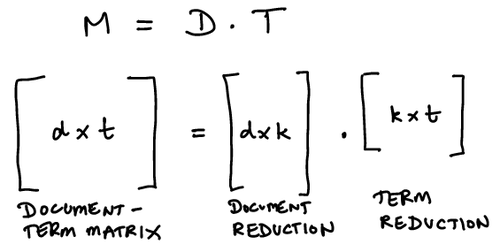

In [ ]:
nb_setup.images_hconcat(["NLP_images/DTM_reduction.png"], width=500)

In [ ]:
# Check for dimension reduction
data_lda.shape

(129971, 3)

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 20.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 93.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 89.4 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=9ff072edc7bda0793c8d20b1c777159f509b8cc3a420869a9746aa950e0ee00c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/eb/d1/ac/e8728b60e7d714da9ff6a52cb8659099c3be9e0dc19f522881
Successfully built pyLDAvis


In [ ]:
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 762 kB/s  eta 0:00:01


In [ ]:
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [ ]:
%%time
pyLDAvis.enable_notebook()
topic_plot = pyLDAvis.sklearn.prepare(lda, DTM, vectorizer, mds='tsne')
topic_plot

CPU times: user 24.1 s, sys: 87.3 ms, total: 24.2 s
Wall time: 25.9 s


PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  37.126561
1      -387.996002  -373.316162       2        1  33.296185
2     -2184.745605   -60.565800       3        1  29.577254, topic_info=         Term          Freq         Total Category  logprob  loglift
11738    wine  79762.000000  79762.000000  Default  30.0000  30.0000
1791   cherry  29241.000000  29241.000000  Default  29.0000  29.0000
401     apple  13595.000000  13595.000000  Default  28.0000  28.0000
464    aromas  39440.000000  39440.000000  Default  27.0000  27.0000
7329   palate  38455.000000  38455.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
11738    wine  14475.055264  79762.337280   Topic3  -4.1299  -0.4885
1208   bright   5895.052023  11015.383566   Topic3  -5.0282   0.5930
10377   sweet   5690.626132  13380.313169   Topic3  -5.0635   0.3632
8724     ripe   5130.656040  27157.694237   Topic3  -5.1671  -0.4483
7084   offers   4691.140838  12448.396079   Topic3  -5.2567   0.2422

[220 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
76         1  0.103145     acidity
76         2  0.482463     acidity
76         3  0.414387     acidity
158        2  0.962867  aftertaste
158        3  0.036786  aftertaste
...      ...       ...         ...
11852      3  0.999891      yellow
11867      1  0.001383       young
11867      2  0.998405       young
11891      3  0.999640        zest
11894      3  0.999865       zesty

[291 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## Non-Negative Matrix Factorization (NMF)

As noted above we are looking to decompose the DTM $M$ into $D \cdot T$, with common dimension of size $k$. 

We apply the Froebenius norm: f = $\parallel M - D \cdot T \parallel_F^2 = \sum_d \sum_t (M_{dt} - D_{dt} T_{dt})^2$. Let the gradient be $\nabla f$.

We minimize $f$ by iteration. First, hold $T$ fixed and find the best $D$, then hold $D$ fixed and find the best $T$. 

If we hold $T$ fixed, and differentiate with respect to a specific $d$: $\nabla f_d = \frac{\partial f}{\partial d} \sum_d \sum_t (M_{dt}^2 - 2 M_{dt} D_{dt} T_{dt} + D_{dt}^2 T_{dt}^2) = 0$. 

We get that $\nabla f_d = \sum_t (MT^\top - DTT^\top) = 0$, which implies that

$$
MT^\top = DTT^\top
$$

We want to choose the elements of $D$ such that 
1. The LHS is as close to the RHS as possible
2. The elements of $D$ are non-negative, else we are not doing NMF






Using gradients, we set up the algorithm as follows:

$$
D \leftarrow D + \eta_D [MT^\top - DTT^\top] 
$$

We can choose the learning rate $\eta_D$ in a clever way to make sure that elements of $D \geq 0$, i.e., $\eta_D = \frac{D}{DTT^\top}$, the fraction taken elementwise. So, we now get

$$
D \leftarrow D + \frac{D}{DTT^\top} [MT^\top - DTT^\top] 
$$

or, elementwise

$$
D_{dt} \leftarrow  D_{dt} \cdot \frac{M_{dt}T_{dt}^\top}{D_{dt}T_{dt}T_{dt}^\top} 
$$

This update rule ensures that $D_{dt} \geq 0, \forall d,t$. 
Correspondingly, the update rule for the elements of $T$ is

$$
T_{dt} \leftarrow  T_{dt} \cdot \frac{D_{dt}^\top M_{dt}}{D_{dt} D_{dt}^\top T_{dt}} 
$$

In [ ]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=n_topics)
data_nmf = nmf.fit_transform(DTM) 

In [ ]:
data_nmf.shape

(129971, 3)

we can get more details here: https://srdas.github.io/MLBook2/24_TextAnaytics_Advanced.html#Non-negative-Matrix-Factorization-(NMF)

You can use this reduced-form matrix for document similarity (for example).

In [ ]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=n_topics)
data_lsi = lsi.fit_transform(DTM)

In [ ]:
data_lsi.shape

(129971, 3)

More details here: https://srdas.github.io/MLBook2/24_TextAnaytics_Advanced.html#Singular-Value-Decomposition-(SVD)